import All necessary libraries and functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


Create Model 

In [3]:
FRmodel=faceRecoModel(input_shape=(3, 96, 96))

In [4]:
FRmodel.count_params()

3743280

define Triplet Loss for Our model(We will use it while compiling our model)

In [6]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    return loss

Let's Compile the model

In [7]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

Instead of training ,We will use pre-trained weights of Facenet. So let's load the weights

In [11]:
load_weights_from_FaceNet(FRmodel)

In [28]:
FRmodel.save("128bitmodel.h5")

In [8]:
FRmodel.load_weights("128bitmodel.h5")

In [9]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [10]:
x_train=[]
y_valid=[]
x_valid=[]
y_train=[]

In [12]:
persons=["viru" ,"vikki","somu","vikram"]

In [13]:
for person in persons:
    if person=="viru":
        j=0
        k=40
    if person=="somu":
        j=1
        k=20
    if person=="vikki":
        j=2
        k=40
    if person=="vikram":
        j=3
        k=40
        
    
    for i in range(k):
        image_path="train/%s/"%(person)+str(i+1)+".jpg"
        encoding=img_to_encoding(image_path ,FRmodel)
        x_train.append(encoding)
        y_train.append(j)
    

In [14]:
x_train[0].shape 

(1, 128)

In [15]:
classify_model=Sequential()

In [16]:
classify_model.add(Dense(128 ,input_shape=(1,128),activation="relu"))

In [17]:
classify_model.add(Dense(4,activation="softmax"))

In [18]:
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.preprocessing import image

In [19]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [20]:
y_train=to_categorical(y_train)

In [21]:
y_train=y_train.reshape(140,1,4)

In [22]:
classify_model.compile(optimizer="adam" ,loss="categorical_crossentropy",metrics=["accuracy"])

In [23]:
classify_model.fit(x_train,y_train ,batch_size=1,epochs=20,shuffle=True,verbose=2)

Epoch 1/20
 - 3s - loss: 1.2274 - acc: 0.5000
Epoch 2/20
 - 0s - loss: 0.8284 - acc: 0.7643
Epoch 3/20
 - 0s - loss: 0.5560 - acc: 0.8857
Epoch 4/20
 - 0s - loss: 0.4061 - acc: 0.9286
Epoch 5/20
 - 0s - loss: 0.3111 - acc: 0.9214
Epoch 6/20
 - 0s - loss: 0.2541 - acc: 0.9500
Epoch 7/20
 - 0s - loss: 0.2120 - acc: 0.9214
Epoch 8/20
 - 0s - loss: 0.1878 - acc: 0.9214
Epoch 9/20
 - 0s - loss: 0.1620 - acc: 0.9500
Epoch 10/20
 - 0s - loss: 0.1474 - acc: 0.9571
Epoch 11/20
 - 0s - loss: 0.1327 - acc: 0.9714
Epoch 12/20
 - 0s - loss: 0.1280 - acc: 0.9500
Epoch 13/20
 - 0s - loss: 0.1109 - acc: 0.9643
Epoch 14/20
 - 0s - loss: 0.1144 - acc: 0.9571
Epoch 15/20
 - 0s - loss: 0.1013 - acc: 0.9714
Epoch 16/20
 - 0s - loss: 0.0933 - acc: 0.9714
Epoch 17/20
 - 0s - loss: 0.0860 - acc: 0.9786
Epoch 18/20
 - 0s - loss: 0.0833 - acc: 0.9714
Epoch 19/20
 - 0s - loss: 0.0705 - acc: 0.9857
Epoch 20/20
 - 0s - loss: 0.0783 - acc: 0.9786


In [24]:
def who_is_it(clas):
    if clas==0:
        print("Hii Viru ,Your attendance has been recorded")
    if clas==1:
        print("Hii Somu ,Your attendance has been recorded")
    if clas==2:
        print("Hii Vikki ,Your attendance has been recorded")
    if clas==3:
        print("Hii Vikram Poonia ,Your attendance has been recorded")
    

In [25]:
def Predict_who(image_path,model1,model2):
    encoding=img_to_encoding(image_path,model1)
    encoding=encoding.reshape(1,1,128)
    clas=model2.predict_classes(encoding)
    who_is_it(clas)
    update_att(clas)

In [26]:
classify_model.save("recognise.h5")

In [27]:
classify_model.load_weights("recognise.h5")

Hii Vikram Poonia ,Your attendance has been recorded


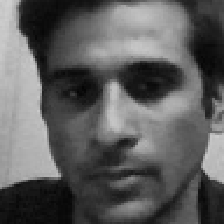

In [70]:
image_path="test/vkrm8.jpg"
img=image.load_img(image_path ,target_size=(224,224))
Predict_who(image_path ,FRmodel ,classify_model)
img

###### 

In [55]:
def img_to_encoding2(image, model):
    img1 = image
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [75]:
import numpy as np
import cv2
import os
import time

cap = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def crop_face(clahe_image, face):
    for (x, y, w, h) in face:
        faceslice = clahe_image[y:y+h, x:x+w]
        faceslice = cv2.resize(faceslice, (96,96))
    return faceslice
    
while True:
    ret,frame=cap.read()
    time.sleep(0.3)
    #cv2.imshow("preview",frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray) 
    face = face_cascade.detectMultiScale(clahe_image, scaleFactor=1.1, minNeighbors=15, minSize=(10, 10), flags=cv2.CASCADE_SCALE_IMAGE)
    for i in range(500):
        pass
    face=np.array(face)
    x=face[0][0]
    y=face[0][1]
    w=face[0][2]
    h=face[0][3]
    img=cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.imshow("img" ,img)    
    key=cv2.waitKey(10)
    if key==27:
        break
    if key==32:
        faceslice = crop_face(clahe_image, face)
        cv2.imwrite("1.jpg",faceslice)
        image_path="1.jpg"
        Predict_who(image_path ,FRmodel ,classify_model)
    

cap.release()
cv2.destroyAllWindows()

Hii Vikram Poonia ,Your attendance has been recorded
Hii Vikram Poonia ,Your attendance has been recorded


Mongo Part


In [32]:
from pymongo import MongoClient 

In [37]:
client=MongoClient()
client = MongoClient('localhost', 27017)
database=client.mydb
collection=database["attendance1"]

In [39]:
collection.update({"Name" : "Somesh"},{ "$inc": {"Att_count" :2}})

{'n': 0, 'nModified': 0, 'ok': 1.0, 'updatedExisting': False}

In [79]:
cursor=collection.find()
for record in cursor:
    print(record[])

2
0
3
2


In [63]:
def update_att(clas):
    if clas==0:
        collection.update({"Name" : "Virendra"},{ "$inc": {"Att_count" :1}})
    if clas==1:
        collection.update({"Name" : "Somesh"},{ "$inc": {"Att_count" :1}})
    if clas==2:
        collection.update({"Name" : "Vikrant"},{ "$inc": {"Att_count" :1}})
    if clas==3:
        collection.update({"Name" : "Vikram"},{ "$inc": {"Att_count" :1}}) 

In [30]:
def reset_att():
    collection.update({"Name" : "Virendra"},{"Name" : "Virendra","Att_count":0 })
    collection.update({"Name" : "Somesh"},{"Name" : "Somesh","Att_count":0 })
    collection.update({"Name" : "Vikrant"},{"Name" : "Vikrant","Att_count":0 })
    collection.update({"Name" : "Vikram"},{"Name" : "Vikram","Att_count":0 })

In [68]:
reset_att()